In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

# use notebook path to find repo root, path to repo parent directory, and airflow dags repo
# note that the two repos must by subdirs in some common parent for this to work
nb_path = Path(os.path.abspath(""))
emp_retention_repo_path = nb_path.parent
all_repos_parent_path = emp_retention_repo_path.parent
# append airflow-dags projs path and emp_retention repo path to python path
sys.path.append(str(emp_retention_repo_path))


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Non exchangeability fixed with cuped
the untreated potential outcomes differ between the treatment group and the control group, this indicates a violation of randomization or exchangeability (sampling)

Lets make a toy dataset where we would get exchangeability issues.  Lets just say they are all centered around a mean and then one of them is 3x the others.

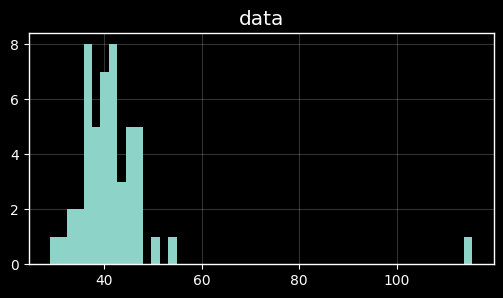

In [90]:
data = np.random.normal(40,4,50)
data[0] *= 3
df = pd.DataFrame(data, columns=['data'])
df.hist(bins=50, figsize=(6,3)); plt.grid(alpha=0.2);

Lets say that `y = b0 + b1 * T` where b0 is the mean of response variable in the control group and b1 is the treatment effect - lets set that to 4.

In [132]:
def simulate_response_variable(df, effect_mu=4, effect_std=0.5):
    '''Single run of the MC'''
    n = df.shape[0]
    mask = np.random.choice(n, size=n//2, replace=False) # includes 0
    df['T'] = df.index.isin(mask).astype(int)
    effects = np.random.normal(loc=effect_mu, scale=effect_std, size=len(df))
    eps = np.random.normal(loc=0, scale=1, size=len(df))
    df['response'] = df['data'] + effects * df['T'] + eps
    return df

df = simulate_response_variable(df)
df.head()

,data,T,response
0,115.565665,0,115.075953
1,45.550092,1,49.346283
2,41.994619,0,41.281231
3,33.707426,0,33.601555
4,41.097817,0,41.658624


In [133]:
from scipy import stats
import statsmodels.api as sm

def calculate_stats(df):
    # split into treated and 
    treated = df.loc[df['T'] == 1,'response']
    control = df.loc[df['T'] == 0,'response']
    effect = treated.mean() - control.mean()

    t_stat, p_val = stats.ttest_ind(treated, control, equal_var=False)
    return effect, t_stat, p_val

calculate_stats(df)

(0.7381656071839728, 0.2251415174983056, 0.8234154762303145)

In [134]:
def run_mc(df, iters=1000):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        effect, t_stat, p_val = calculate_stats(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df
n_iters = 1000
mc_df = run_mc(df, iters=n_iters)
mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,8.349943,2.549118,0.016609,1
1,3.272183,0.981314,0.335224,0
2,0.992492,0.301675,0.765071,0
3,8.522616,2.644380,0.012970,1
4,6.610271,2.014974,0.053342,1


> So we're only "right" in our decision 27.5% of the time and it's because the variance is so high.  So our type 2 error rate is super high (we are constantly rejecting the null eventhough there is a huge effect)

In [142]:
(mc_df.p_val < 0.05).sum() / n_iters

0.275

(3.987327082420949, 3.3119537945424)

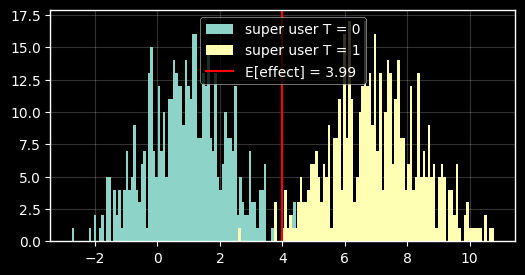

In [135]:
plt.figure(figsize=(6,3))
for super_user_grp in [0,1]:
    mc_df.query(f'super_user_grp =={super_user_grp}').effect.hist(bins=100,label=f'super user T = {super_user_grp}')
plt.grid(alpha=0.2); 

# calculate the E[effect] and variance
expected_effect = mc_df.effect.mean()
std_effect = mc_df.effect.std()
# add to the plot
plt.axvline(expected_effect,c='r',label=f'E[effect] = {round(expected_effect,2)}')
plt.legend();

expected_effect, std_effect

> Lets see if we can fix this with cupid

In [136]:
import statsmodels.formula.api as smf

def cupid_regression(df, y_col="response", t_col="T", x_col="data"):
    d = df[[y_col, t_col, x_col]].dropna()

    # Y ~ T + X includes an intercept by default
    model = smf.ols(f"{y_col} ~ {t_col} + {x_col}", data=d)
    # fit the model
    res = model.fit()
    # pull relevant information
    effect, t_stat, p_val = res.params["T"], res.tvalues["T"], res.pvalues["T"]
    return res, effect, t_stat, p_val

res, effect, t_stat, p_val = cupid_regression(df)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4587.
Date:                Fri, 09 Jan 2026   Prob (F-statistic):           1.33e-54
Time:                        15:38:44   Log-Likelihood:                -62.629
No. Observations:                  50   AIC:                             131.3
Df Residuals:                      47   BIC:                             137.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5931      0.471      1.259      0.2

In [137]:
def cupid_mc(df,iters=1000):
    outs = []
    for _ in range(iters):
        # split into groups
        grouped_df = simulate_response_variable(df)
        # keep track of which group the super user ended up in (just for demonstrating the point)
        super_user_grp = grouped_df['T'].iloc[0] # its the first row
        # calculate the effect and t test stats
        res, effect, t_stat, p_val = cupid_regression(grouped_df)
        outs.append([effect, t_stat, p_val, super_user_grp])
    out_df = pd.DataFrame(outs, columns = ['effect', 't_stat', 'p_val', 'super_user_grp'])
    return out_df

n_iters = 1000
cupid_mc_df = cupid_mc(df, iters=1000)
cupid_mc_df.head()

,effect,t_stat,p_val,super_user_grp
0,3.609510,11.336540,4.795844e-15,0
1,3.614602,12.051513,5.567533e-16,1
2,4.258685,15.522927,3.985757e-20,0
3,3.932724,13.805295,3.730686e-18,1
4,3.962750,17.692575,2.056156e-22,1


> With a toy example, we completely eliminate the issue. We are "right" 100% of the time and now this sample size is more than adequate

In [143]:
print((cupid_mc_df.p_val < 0.05).sum() / n_iters)
# calculate the E[effect] and variance
expected_effect = cupid_mc_df.effect.mean()
std_effect = cupid_mc_df.effect.std()
expected_effect, std_effect

1.0


(3.998632646213889, 0.30918974073870426)

# walmart csv
- 143 weeks starting from Feb 2010 and ending on Oct 2012 (let's make the treatment period start on `'2012-06-08'` )
- 45 stores
- seems uniformly distributed at the moment, let's make a pareto distributed column
    - this way we can have some heterogenous splitting issues to play with
    - can make it more heterogenous by dropping `a` the pareto shape parameter (also make sure to rescale so the dollar amounts aren't weird) - 0.5 goes well with 1e12 for example and looks like state distributions (ie CA much bigger and NY and TX close together but also separate from rest or something) but that's all just empiracally playing around

In [4]:
# download and format
df = pd.read_csv('Walmart.csv')
df.columns = [col.lower() for col in df.columns]
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")

# add a pareto sales column (see plots below)
min_val = df.weekly_sales.quantile(0.1)
a = 0.5 # Pareto shape parameter
rescale_multiplier = 1e12 # rescale multiplier puts in similar dollars scale as true data
df['pareto_sales'] = np.round(min_val / df.weekly_sales ** (1/a) * rescale_multiplier, 2) # play with these to make them be similar scales as true

# print some stats
display(df.shape)
df.head(2)

(6435, 9)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,pareto_sales
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,142178.13
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,142478.49


In [4]:
df[['weekly_sales','pareto_sales']].describe()

,weekly_sales,pareto_sales
count,6.435000e+03,6.435000e+03
mean,1.046965e+06,9.672588e+05
std,5.643666e+05,1.277846e+06
min,2.099862e+05,2.634178e+04
25%,5.533501e+05,1.904581e+05
50%,9.607460e+05,4.161557e+05
75%,1.420159e+06,1.254509e+06
max,3.818686e+06,8.711469e+06


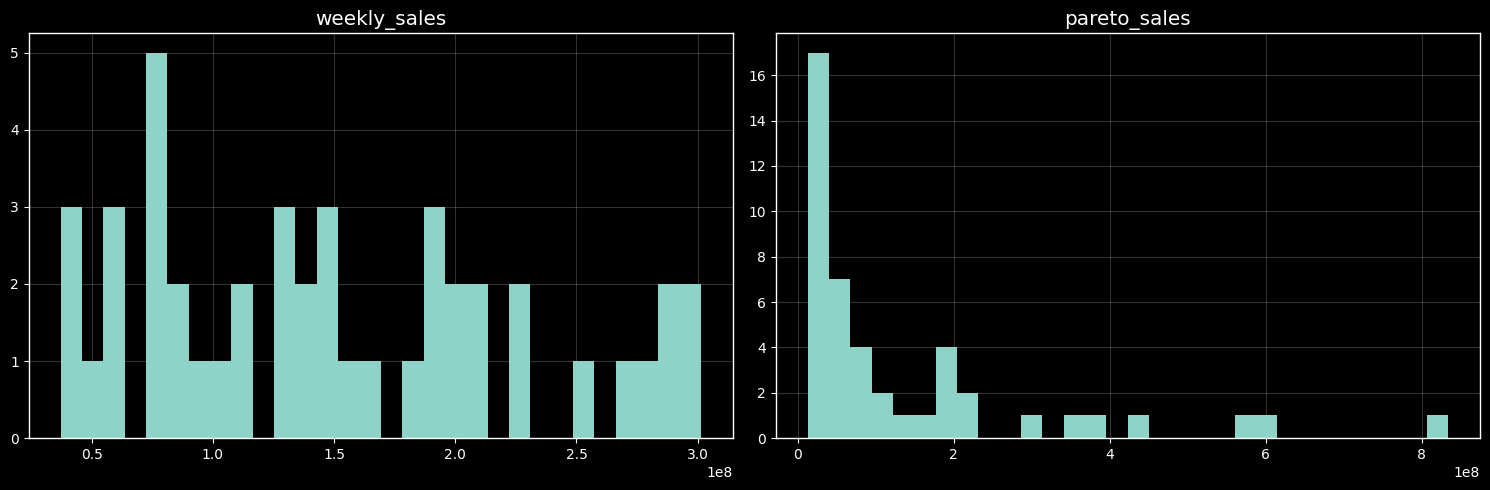

In [5]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

for ax, sales_col in zip(axes,['weekly_sales','pareto_sales']):
    df.groupby('store')[sales_col].sum().hist(bins=30, ax=ax)
    ax.set_title(sales_col); ax.grid(alpha=0.2)
plt.tight_layout()

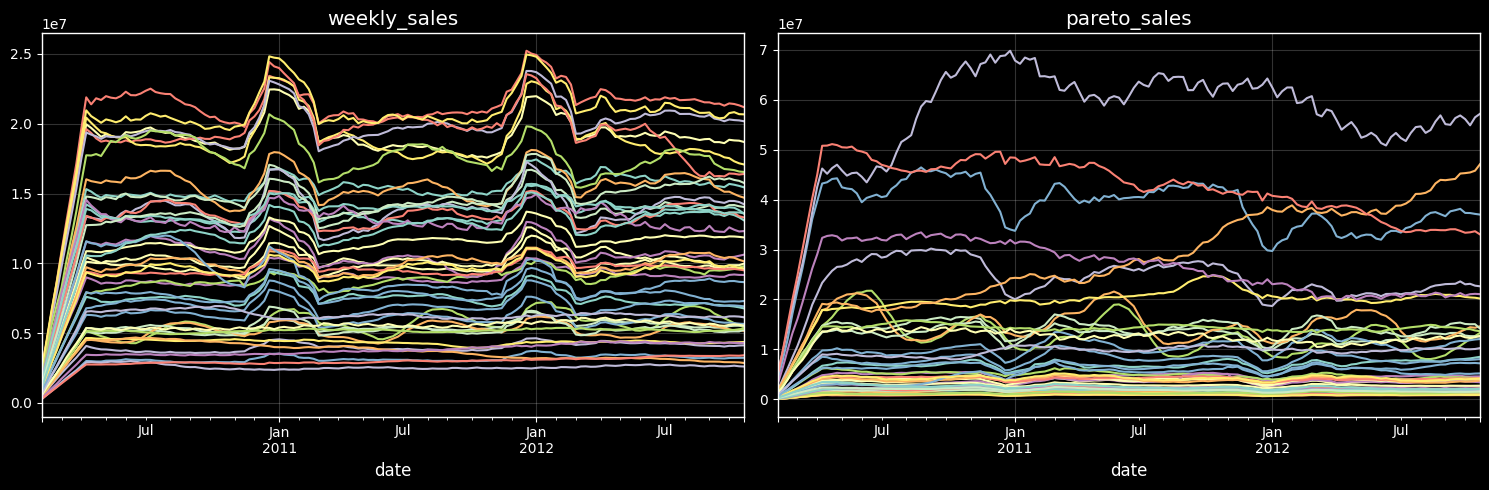

In [44]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
temp_df = df.set_index(['store','date'])

for ax, sales_col in zip(axes,['weekly_sales','pareto_sales']):
    for store in range(1,46):
        temp_df.loc[store, sales_col].rolling(10,1).sum().plot(ax=ax)
    ax.set_title(sales_col); ax.grid(alpha=0.2)
plt.tight_layout()



### Simulate a treatment for one run

> visualize with normal sales

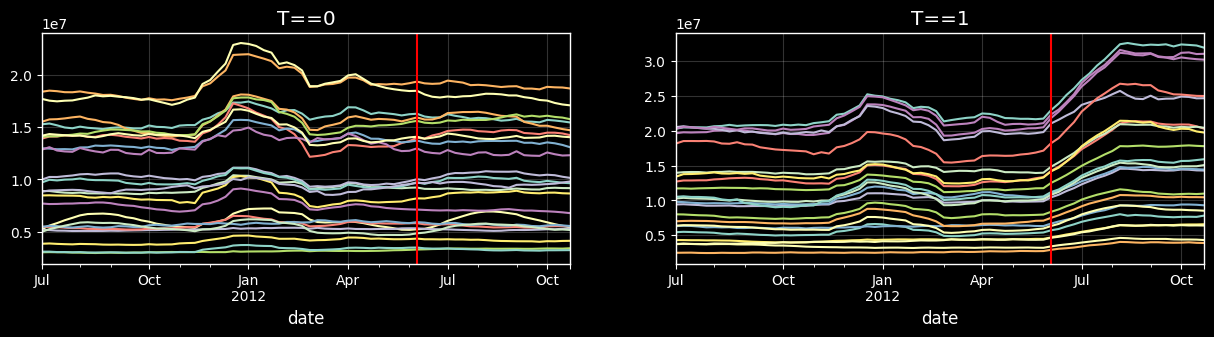

In [93]:
from walmart_utils import TreatedDF

sales_col='weekly_sales'

# make a big effect
run = TreatedDF(df, sales_col=sales_col, effect_params=(0.5, 0.02))
adj_sales_col = 'adj_sales' # same regardless of pareto or regular
fig, axes = plt.subplots(1,2,figsize=(15,3))

for ax, treated in zip(axes,[0,1]):
    temp_df = run.df.loc[run.df['T']==treated].set_index(['date']).sort_index()
    for store in temp_df.store.unique():
        temp_df.loc[temp_df.store==store, adj_sales_col].rolling(10,1).sum().iloc[-70:].plot(ax=ax)
    ax.grid(alpha=0.2); ax.set_title(f'T=={treated}');
    ax.axvline(run.intervention_date, c='r')

> visualize with pareto sales

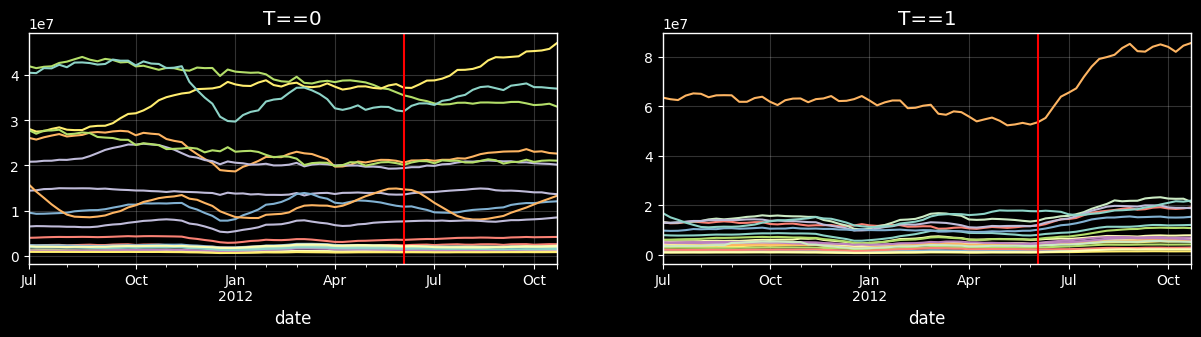

In [94]:
sales_col='pareto_sales'

# make a big effect
run = TreatedDF(df, sales_col=sales_col, effect_params=(0.5, 0.02))
adj_sales_col = 'adj_sales' # same regardless of pareto or regular
fig, axes = plt.subplots(1,2,figsize=(15,3))

for ax, treated in zip(axes,[0,1]):
    temp_df = run.df.loc[run.df['T']==treated].set_index(['date']).sort_index()
    for store in temp_df.store.unique():
        temp_df.loc[temp_df.store==store, adj_sales_col].rolling(10,1).sum().iloc[-70:].plot(ax=ax)
    ax.grid(alpha=0.2); ax.set_title(f'T=={treated}');
    ax.axvline(run.intervention_date, c='r')

### Run an MC simulation for power analysis

> see that with such a small sample it's nearly impossible to power with just a typical t test (even with huge effect sizes)
- not to mention, we didn't even AA test the stat properties to start with so we may have non-exchangeability issues already
- continue with chatgpt code here https://chatgpt.com/c/68a233b4-f928-832c-9b9a-59232c36395c

In [85]:
from walmart_utils import MCSimulation

powers = []
effect_sizes = np.linspace(0,0.4,9)

for effect_size in effect_sizes:
    simul = MCSimulation(df, effect_params = (effect_size, effect_size * 0.02), pre_or_post='post')
    out_df = simul.run_many_simulations(n_sim=1000)
    power = sum(out_df.pval <= 0.05) / out_df.shape[0]
    print(effect_size,power)
    powers.append(power)

0.0 0.049
0.05 0.051
0.1 0.093
0.15000000000000002 0.128
0.2 0.189
0.25 0.272
0.30000000000000004 0.339
0.35000000000000003 0.424
0.4 0.549


> Using pre data, may not make the most sense because actually in reality it will all be pre we just choose some of it to be "treated" for our simulation

In [77]:
from walmart_utils import MCSimulation

simul = MCSimulation(df, effect_params = (0.5, 0.02), pre_or_post='pre')
# simul.generate_single_run_results()
out_df = simul.run_many_simulations(n_sim=1000)

sum(out_df.pval <= 0.05) / out_df.shape[0]

0.05

> visually inspect

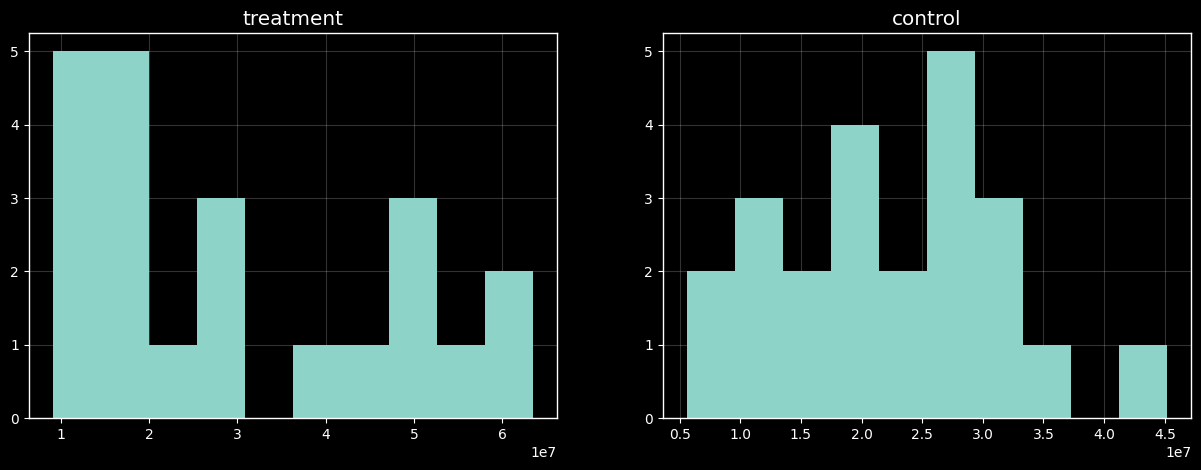

In [218]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

for ax, ser, name in zip(axes,[treated, control],['treatment','control']):
    ser.hist(ax=ax); ax.grid(alpha=0.2), ax.set_title(name)